# **Capítulo 4: Perceptrón multicapa**

## Clasificación de dígitos manuscritos usando la base de datos MNIST

Carga y preprocesado de datos

In [15]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

tam_batch = 32

# Datos de entrenamiento:
train_dataset = datasets.MNIST(
    root='./datos', # Ruta donde se almacenarán los datos descargados
    train=True,     # Datos de entrenamiento
    transform=transforms.ToTensor(), # Conversión más normalización
    download=True   # Se descargan a la carpeta indicada en root
)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_set,      # Dataset sobre el que iterar
    batch_size=tam_batch,
    shuffle=True    # Se mezclan los datos en cada época de entrenamiento
)

val_loader = torch.utils.data.DataLoader(
    val_set,        # Dataset sobre el que iterar
    batch_size=tam_batch,
    shuffle=True    # Se mezclan los datos en cada época de entrenamiento
)

# Datos de test
test_dataset = datasets.MNIST(
    root='./datos', # Misma ruta que los datos de entrenamiento
    train=False,    # Datos de test
    transform=transforms.ToTensor() # Conversión más normalización
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=tam_batch,
    shuffle=False   # Los datos se evalúan siempre en el mismo orden
)

Visualización del aspecto de los datos

Tamaño del conjunto de entrenamiento: 50000
Tamaño del conjunto de validación: 10000
Tamaño del conjunto de test: 10000
Tamaño de las imágenes: torch.Size([1, 28, 28])


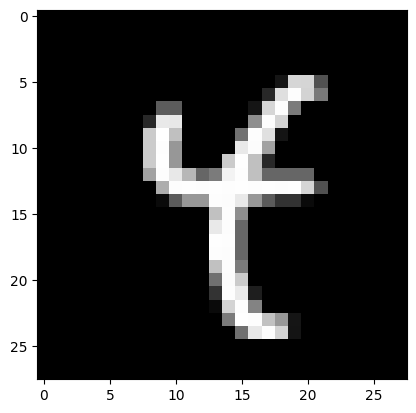

Ejemplo de etiqueta: 4


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(train_set)}')
print(f'Tamaño del conjunto de validación: {len(val_set)}')
print(f'Tamaño del conjunto de test: {len(test_dataset)}')

# Obtenemos un lote o batch de imágenes de entrenamiento
imagenes, etiquetas = next(iter(train_loader))
print(f'Tamaño de las imágenes: {imagenes.shape[1:]}')

# Visualizamos un imagen junto a su etiqueta
id_ejemplo = 10
plt.imshow(np.squeeze(imagenes[id_ejemplo]), cmap='gray')
plt.show()
print(f'Ejemplo de etiqueta: {etiquetas[id_ejemplo]}')

Definición de la arquitectura de red

In [17]:
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()

    self.backbone = nn.Sequential( #https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential
        nn.Linear(in_features=784, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=10),
        nn.Softmax(dim=1)
    )

  def forward(self, input):
    input = torch.flatten(input.squeeze(1), start_dim=1, end_dim=2)
    return self.backbone(input)


Creación del modelo, de la función de pérdida y del optimizador

In [18]:
from torch import optim

modelo = MLP()
print(modelo)

# Si disponemos de GPU, la usamos
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(dispositivo)
print(f'Usando {dispositivo}')

func_perdida = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters())


MLP(
  (backbone): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)
Usando cuda


Función de entrenamiento del modelo

In [19]:
def epoca_train(modelo, train_loader, optimizador, func_perdida, dispositivo):
    epoca_perdidas = []

    # Iteramos sobre los datos de entrenamiento
    for i, (imagenes, etiquetas) in enumerate(train_loader):
        # Si es posible, transferimos los datos a la GPU
        imagenes = imagenes.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        # Ponemos los gradientes a cero
        optimizador.zero_grad()

        # Calculamos las salidas de la red neuronal
        # para las imágenes de entrada
        salidas = modelo(imagenes)

        # Calculamos la pérdida de la red neuronal
        perdida = func_perdida(salidas, etiquetas)

        # Calculamos los gradientes de la pérdida
        # respecto a los parámetros de la red neuronal
        perdida.backward()

        # Actualizamos los parámetros de la red neuronal
        # usando el algoritmo de optimización
        optimizador.step()

        # Añadimos a la lista de pérdidas la pérdida actual
        epoca_perdidas.append(perdida.item())

    # Calculamos la media de las pérdidas para una época
    return sum(epoca_perdidas) / len(epoca_perdidas)

Función de evaluación del modelo

In [20]:
def epoca_test(modelo, test_loader, dispositivo):
    # Establecemos la red neuronal en modo de evaluación
    modelo.eval()

    # Desactivamos el cálculo de gradientes
    with torch.no_grad():
        correcto = 0
        total = 0

        # Iteramos sobre los datos de test
        for imagenes, etiquetas in test_loader:
            # Si es posible, transferimos los datos a la GPU
            imagenes = imagenes.to(dispositivo)
            etiquetas = etiquetas.to(dispositivo)

            # Calculamos las salidas de la red neuronal
            # para las imágenes de entrada
            salidas = modelo(imagenes)

            # Calculamos las probabilidades de las clases
            salidas = salidas.softmax(dim=1)

            # Obtenemos la clase con mayor probabilidad
            prediccion = salidas.argmax(dim=1)

            # Incrementamos el contador de imágenes procesadas
            total += etiquetas.size(0)

            # Incrementamos el contador de imágenes
            # clasificadas correctamente
            correcto += (prediccion == etiquetas).sum().item()

        # Calculamos la exactitud
        exactitud = 100 * correcto / total

    # Establecemos la red neuronal en modo entrenamiento
    modelo.train()
    return exactitud

Entrenamiento del modelo

In [26]:
# Histórico de valores de exactitud de entrenamiento
train_accs = []

# Histórico de valores de exactitud de test
val_accs = []

# Definimos el número de épocas de entrenamiento
epocas = 15
torch.manual_seed(0)
# Iteramos por cada época
for epoca in range(epocas):
    # Entrenamos la red neuronal por una época
    train_perdida = epoca_train(
        modelo, train_loader, optimizador, func_perdida, dispositivo)

    # Calculamos la exactitud para los datos de entrenamiento
    train_acc = epoca_test(modelo, train_loader, dispositivo)
    train_accs.append(train_acc)

    # Calculamos la exactitud para los datos de test
    val_acc = epoca_test(modelo, val_loader, dispositivo)
    val_accs.append(val_acc)

    # Sacamos los resultados por pantalla
    print(f'Época {epoca+1}/{epocas},\
            pérdida={train_perdida:.4f},\
            exactitud_train={train_acc:.2f}%,\
            exactitud_validacion={val_acc:.2f}%')

# Se ha completado el entrenamiento de la red neuronal
print('Fin del entrenamiento.')

Época 1/15,            pérdida=1.4697,            exactitud_train=99.33%,            exactitud_validacion=98.08%
Época 2/15,            pérdida=1.4698,            exactitud_train=99.27%,            exactitud_validacion=98.02%
Época 3/15,            pérdida=1.4691,            exactitud_train=99.34%,            exactitud_validacion=98.03%
Época 4/15,            pérdida=1.4690,            exactitud_train=99.21%,            exactitud_validacion=97.97%
Época 5/15,            pérdida=1.4686,            exactitud_train=99.18%,            exactitud_validacion=97.70%
Época 6/15,            pérdida=1.4689,            exactitud_train=99.48%,            exactitud_validacion=98.09%
Época 7/15,            pérdida=1.4680,            exactitud_train=99.29%,            exactitud_validacion=97.86%
Época 8/15,            pérdida=1.4677,            exactitud_train=99.27%,            exactitud_validacion=97.85%
Época 9/15,            pérdida=1.4673,            exactitud_train=99.47%,            exactitud_v

Visualización de los resultados en entrenamiento y validación

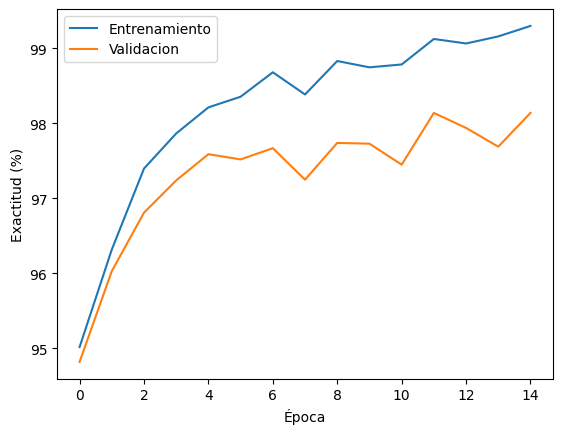

In [22]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel('Época')         # Eje X - Época
plt.ylabel('Exactitud (%)') # Eje Y - Exactitud
plt.legend(['Entrenamiento', 'Validacion'])
plt.show()

Evaluación del modelo con el conjunto de test

In [23]:
test_acc = epoca_test(modelo, test_loader, dispositivo)

print(f"Exactitud test: {test_acc:.2f}%")

Exactitud test: 97.85%


Guardado del modelo

In [24]:
torch.save(modelo.state_dict(), 'pesos.pth')

Carga y evaluación del modelo

In [25]:
nuevo_modelo = MLP()
nuevo_modelo.load_state_dict(torch.load('pesos.pth'))
nuevo_modelo.to(dispositivo)

test_acc = epoca_test(nuevo_modelo, test_loader, dispositivo)

print(f"Exactitud test: {test_acc:.2f}%")

Exactitud test: 97.85%
